In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RAND_STATE_VALUE = 42
DATA_TEST_PATH = "/kaggle/input/landuse-scene-classification/images_train_test_val/test"
DATA_TRAIN_PATH = "/kaggle/input/landuse-scene-classification/images_train_test_val/train"
DATA_VAL_PATH = "/kaggle/input/landuse-scene-classification/images_train_test_val/validation"
IMG_SIZE = (256, 256)
IMG_SHAPE = (256, 256, 3)
LABEL_MODE = "categorical"

# Load Data

In [3]:
train_ds = image_dataset_from_directory(directory = DATA_TRAIN_PATH, label_mode = LABEL_MODE, image_size = IMG_SIZE)
test_ds = image_dataset_from_directory(directory = DATA_TEST_PATH, label_mode = LABEL_MODE, image_size = IMG_SIZE)
val_ds = image_dataset_from_directory(directory = DATA_VAL_PATH, label_mode = LABEL_MODE, image_size = IMG_SIZE)

Found 7350 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.


In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32, 21)


In [5]:
class_names = train_ds.class_names
class_names

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

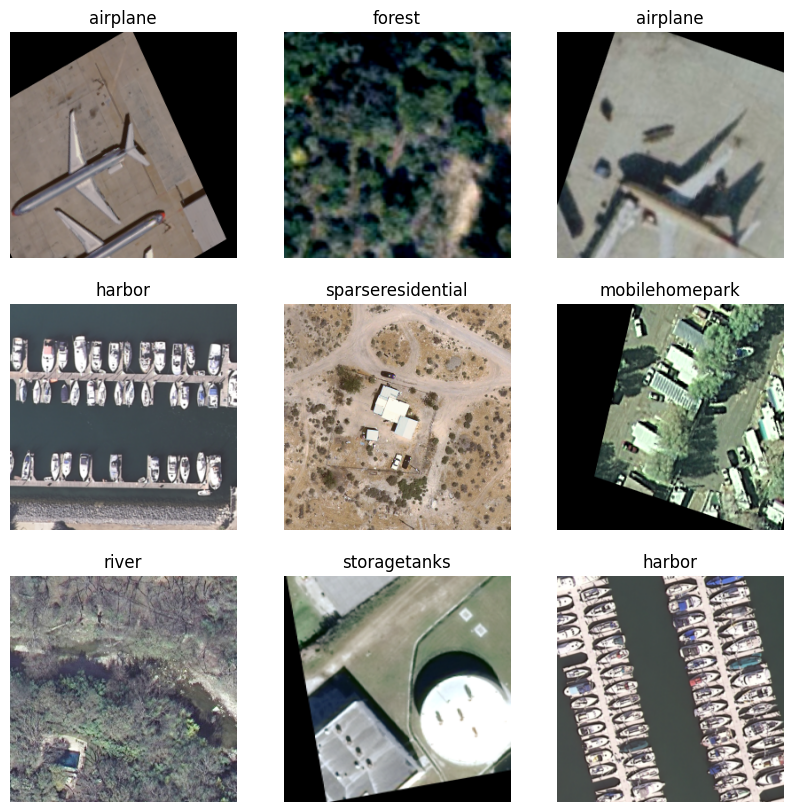

In [6]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

# Model Creation

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [8]:
data_augmentation = Sequential([
    layers.RandomFlip(input_shape = IMG_SHAPE),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.Rescaling(1./255)
])

In [9]:
model = Sequential([
    data_augmentation,
    layers.Conv2D(64, (5, 5), activation = "relu", kernel_regularizer = l2(0.00005)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation = "relu", kernel_regularizer = l2(0.00005)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation = "relu", kernel_regularizer = l2(0.00005)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation = "relu"),
    layers.Dense(len(train_ds.class_names), activation = "softmax")
])

In [10]:
optimizer = Adam(learning_rate = 0.0001)

In [11]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)       

In [13]:
history = model.fit(train_ds, epochs = 200, validation_data = val_ds, verbose = 1)

Epoch 1/200


2023-12-16 20:11:43.344724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


230/230 [==============================] - 35s 124ms/step - loss: 4.2352 - accuracy: 0.2250 - val_loss: 9.5038 - val_accuracy: 0.0500
Epoch 2/200
230/230 [==============================] - 28s 119ms/step - loss: 3.1778 - accuracy: 0.3098 - val_loss: 6.2327 - val_accuracy: 0.1043
Epoch 3/200
230/230 [==============================] - 28s 119ms/step - loss: 2.8875 - accuracy: 0.3537 - val_loss: 3.8507 - val_accuracy: 0.2971
Epoch 4/200
230/230 [==============================] - 28s 119ms/step - loss: 2.6062 - accuracy: 0.3992 - val_loss: 2.6403 - val_accuracy: 0.3938
Epoch 5/200
230/230 [==============================] - 28s 120ms/step - loss: 2.3029 - accuracy: 0.4321 - val_loss: 2.7601 - val_accuracy: 0.3810
Epoch 6/200
230/230 [==============================] - 28s 119ms/step - loss: 2.0125 - accuracy: 0.4816 - val_loss: 2.7879 - val_accuracy: 0.3529
Epoch 7/200
230/230 [==============================] - 28s 120ms/step - loss: 1.8578 - accuracy: 0.5054 - val_loss: 1.9203 - val_accurac

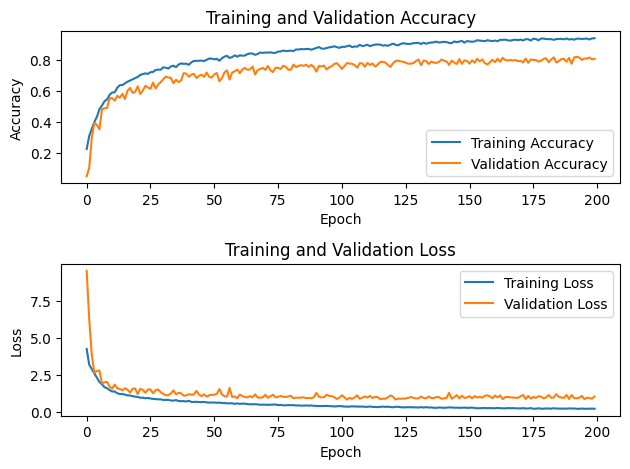

In [14]:
# Plot training history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Model Testing and Evaluation

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [16]:
def decode_labels(labels):
    return np.argmax(labels, axis = 1)

In [17]:
true_labels = []
all_pred_classes = []

for images, labels in test_ds:
    predictions = model.predict(images)
    pred_classes = decode_labels(predictions)
    
    true_labels.extend(decode_labels(labels))
    all_pred_classes.extend(pred_classes)

1/1 [==============================] - 0s 423ms/step


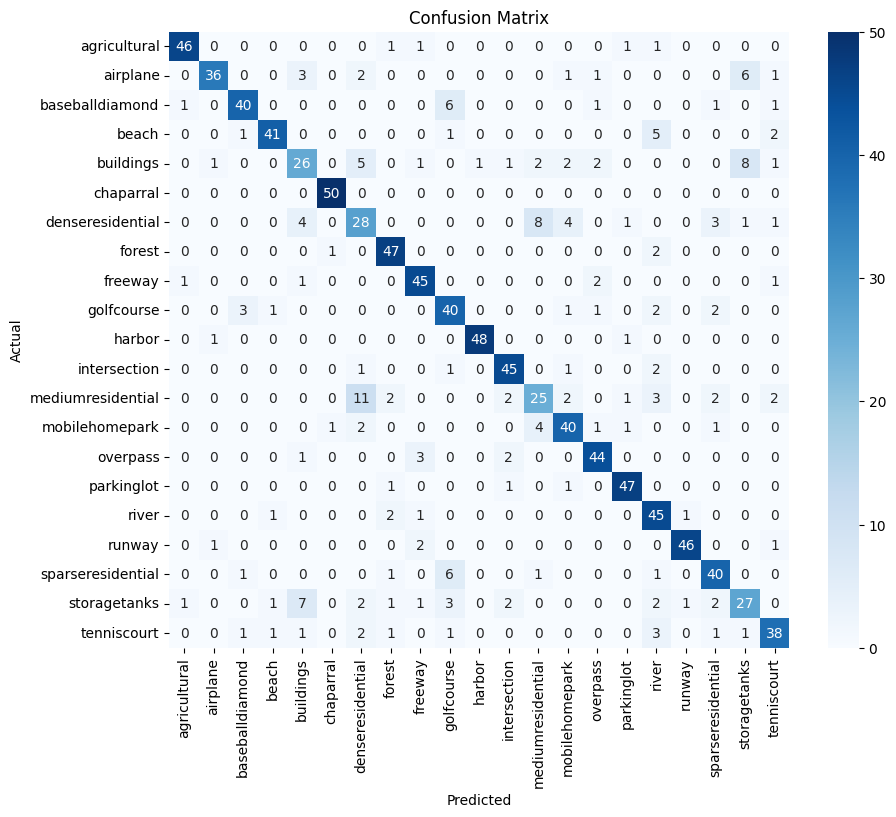

In [18]:
cmt = confusion_matrix(true_labels, all_pred_classes)

plt.figure(figsize = (10, 8))
sns.heatmap(cmt, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
report = classification_report(true_labels, all_pred_classes, target_names = class_names)
print("Classification Report:")
print(report)

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.94      0.92      0.93        50
         airplane       0.92      0.72      0.81        50
  baseballdiamond       0.87      0.80      0.83        50
            beach       0.91      0.82      0.86        50
        buildings       0.60      0.52      0.56        50
        chaparral       0.96      1.00      0.98        50
 denseresidential       0.53      0.56      0.54        50
           forest       0.84      0.94      0.89        50
          freeway       0.83      0.90      0.87        50
       golfcourse       0.69      0.80      0.74        50
           harbor       0.98      0.96      0.97        50
     intersection       0.85      0.90      0.87        50
mediumresidential       0.62      0.50      0.56        50
   mobilehomepark       0.77      0.80      0.78        50
         overpass       0.85      0.88      0.86        50
       parkinglot       0.90    

1/1 [==============================] - 0s 48ms/step


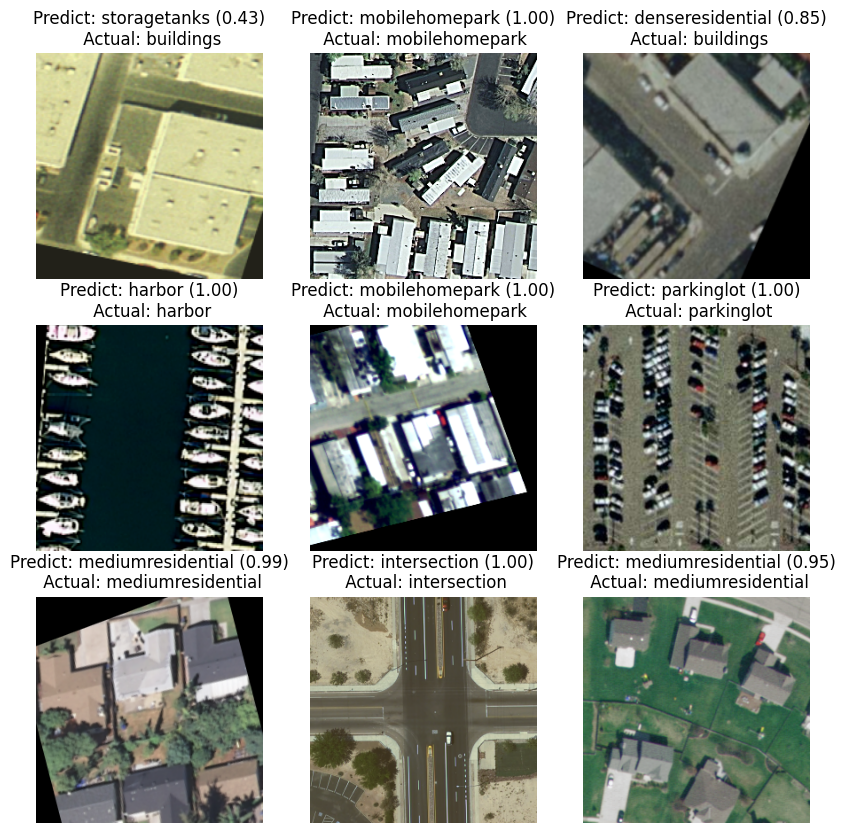

In [20]:
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    pred_classes = decode_labels(predictions)
    
    plt.figure(figsize = (10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = class_names[pred_classes[i]]
        true_class = class_names[np.argmax(labels[i])]
        prob = np.max(predictions[i])
        plt.title(f"Predict: {pred_class} ({prob:.2f})\n Actual: {true_class}")
        plt.axis("off")
    plt.show()